In [1]:
import pandas as pd
import re
import pickle
import datetime
#import textdistance
import json
import numpy as np
import wikipedia as wiki
path_data= 'C:/root/Universita/project_dmdv/data/'




#some useful functions

#funzione per la sostituzione sulla base di una regex, la funzione nativa va in errore se il valore è null
def regex_replace(regex, sub, string):
    if pd.isnull(string):
        return None
    else:
        return re.sub(regex, sub, string)
    
#funzione per la sostituzione sulla base di una regex, la funzione nativa va in errore se il valore è stringa vuota
def regex_replace2(regex, sub, string):
    if pd.isnull(string):
        return ''
    else:
        return re.sub(regex, sub, string)

#matching sulla base di una regex, la f nativa va in errore se il valore è mancante
def regex_match(regex, string, reverse = False):
    if pd.isnull(string):
        return None
    else:
        return re.match(regex, string)
    
#is_winner
def get_winner(string):
    if string:
        return 'Winner'
    else:
        return 'Nominee'


#funzione per la sostituzione delle stringe contententi solo spazi
def replace_na_string(string):
    str_out = string
    if pd.notnull(string):
        if string.replace(' ', '') == '':
            str_out = None
    return str_out

#estrazione sottostringa (se pd.NoneType, lo slicing di python base va in errore)
def substring(string, start, end):
    str_out = None
    if pd.notnull(string):
        str_out = string[start:end]
    return str_out

# IMPORT

In [2]:
data_award = pd.read_pickle(path_data + 'awards/movies_awards.data')
data_award.head()

,award,year,program,person,is_winner,award_type,title_upper,award_id
0,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE,aw-1
1,ACTOR,1927.0,The Last Command,[Emil Jannings],Winner,oscar award,THE LAST COMMAND,aw-2
2,ACTRESS,1927.0,A Ship Comes In,[Louise Dresser],Nominee,oscar award,A SHIP COMES IN,aw-3
3,ACTRESS,1927.0,7th Heaven,[Janet Gaynor],Winner,oscar award,7TH HEAVEN,aw-4
4,ACTRESS,1927.0,Sadie Thompson,[Gloria Swanson],Nominee,oscar award,SADIE THOMPSON,aw-5


### TMDB Movies

In [3]:
tmdb_movies_complete = pd.read_json(path_data + 'tmdb/json/tmdb_movies.json')
tmdb_movies_complete.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movie_id
0,False,/dvQj1GBZAZirz1skEEZyWH2ZqQP.jpg,"{'id': 177062, 'name': 'Blondie Collection', '...",0,"[{'id': 35, 'name': 'Comedy'}]",None,3924,tt0029927,en,Blondie,...,0,70.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,Blondie,False,6.6,4,m-1
1,False,None,None,0,"[{'id': 12, 'name': 'Adventure'}]",None,6124,tt0011436,de,Der Mann ohne Namen,...,0,420.0,[],Released,None,"Peter Voss, Thief of Millions",False,0.0,0,m-2
2,False,/uJlc4aNPF3Y8yAqahJTKBwgwPVW.jpg,None,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",None,8773,tt0055747,fr,L'amour à vingt ans,...,0,110.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The Intimate Secrets of Young Lovers,Love at Twenty,False,6.9,29,m-3
3,False,/nHsBik6CaJnxWad6oStfld9eamk.jpg,None,0,"[{'id': 35, 'name': 'Comedy'}]",None,21624,None,pa,Jatts in Golmaal,...,0,NaN,[],Released,None,Jatts in Golmaal,False,0.0,0,m-4
4,False,None,"{'id': 425256, 'name': 'New World Disorder', '...",0,[],http://www.nwdfilms.com,25449,None,en,New World Disorder 9: Never Enough,...,0,69.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,New World Disorder 9: Never Enough,False,4.5,2,m-5


In [4]:
tmdb_movies_complete['original_title'] = pd.core.strings.str_strip(tmdb_movies_complete['original_title'])
#trim
tmdb_movies_complete['title'] = pd.core.strings.str_strip(tmdb_movies_complete['title'])
tmdb_movies_complete = (tmdb_movies_complete[['id', 'budget', 'genres', 'imdb_id', 'original_language', 'original_title',  'popularity',
                      'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 
                      'tagline', 'title', 'video', 'vote_average', 'vote_count','poster_path','overview','spoken_languages', 'movie_id']])

In [5]:
#conversione data ed estrazione anno
tmdb_movies_complete['release_date'] = pd.to_datetime(tmdb_movies_complete['release_date'], format = "%Y-%m-%d")
tmdb_movies_complete['year_movie'] = tmdb_movies_complete['release_date'].apply(lambda row: float(row.year))

In [6]:
#dataset con attributi rilevanti per l'integrazione
tmdb_movies = tmdb_movies_complete.copy()[['original_title','year_movie', 'title', 'movie_id']]

#upper case
tmdb_movies['original_title'] = tmdb_movies['original_title'].apply(lambda row: row.upper() if pd.notnull(row) else None)
tmdb_movies['title'] = tmdb_movies['title'].apply(lambda row:  row.upper() if pd.notnull(row) else None)
tmdb_movies.head()

,original_title,year_movie,title,movie_id
0,BLONDIE,1938.0,BLONDIE,m-1
1,DER MANN OHNE NAMEN,1921.0,"PETER VOSS, THIEF OF MILLIONS",m-2
2,L'AMOUR À VINGT ANS,1962.0,LOVE AT TWENTY,m-3
3,JATTS IN GOLMAAL,2003.0,JATTS IN GOLMAAL,m-4
4,NEW WORLD DISORDER 9: NEVER ENOUGH,2008.0,NEW WORLD DISORDER 9: NEVER ENOUGH,m-5


In [7]:
#def na per le stringhe
tmdb_movies['title'] = tmdb_movies['title'].apply(lambda row: replace_na_string(row))
tmdb_movies['original_title'] = tmdb_movies['original_title'].apply(lambda row: replace_na_string(row))

In [8]:
tmdb_movies.head()

,original_title,year_movie,title,movie_id
0,BLONDIE,1938.0,BLONDIE,m-1
1,DER MANN OHNE NAMEN,1921.0,"PETER VOSS, THIEF OF MILLIONS",m-2
2,L'AMOUR À VINGT ANS,1962.0,LOVE AT TWENTY,m-3
3,JATTS IN GOLMAAL,2003.0,JATTS IN GOLMAAL,m-4
4,NEW WORLD DISORDER 9: NEVER ENOUGH,2008.0,NEW WORLD DISORDER 9: NEVER ENOUGH,m-5


### ENRICHMENT

##### Title Upper

In [9]:
#merge per title upper
award_title = data_award.merge(
    tmdb_movies[pd.notnull(tmdb_movies['title'])],
    how = 'left', left_on = 'title_upper', right_on = 'title'
)

#split trovati e non trovati
award_title_founded = award_title.copy()[pd.notnull(award_title['movie_id'])]
award_title_founded['source'] = 'upper_title'
award_title_notFounded = award_title.copy()[pd.isnull(award_title['movie_id'])]

In [10]:
print('Totali: ' + str(len(award_title['award_id'].unique())))
print('Trovati: ' + str(len(award_title_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_title_notFounded['award_id'].unique())))

Totali: 14026
Trovati: 13144
Non trovati: 882


In [11]:
#merge per original title upper
award_originalTitle = data_award.merge(
    tmdb_movies[pd.notnull(tmdb_movies['original_title'])],
    how = 'left', left_on = 'title_upper', right_on = 'original_title'
)

#split trovati e non trovati
award_originalTitle_founded = award_originalTitle.copy()[pd.notnull(award_originalTitle['movie_id'])]
award_originalTitle_founded['source'] = 'upper_original'
award_originalTitle_notFounded = award_originalTitle.copy()[pd.isnull(award_originalTitle['movie_id'])]

In [12]:
print('Totali: ' + str(len(award_originalTitle['award_id'].unique())))
print('Trovati: ' + str(len(award_originalTitle_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_originalTitle_notFounded['award_id'].unique())))

Totali: 14026
Trovati: 12717
Non trovati: 1309


In [13]:
#totali non trovati
award_notFounded_upper = award_originalTitle_notFounded[['award_id']].merge(
    award_title_notFounded,
    how = 'inner', on = 'award_id'
)[['award_id', 'award', 'year', 'program', 'person', 'is_winner',
       'award_type', 'title_upper']]
award_notFounded_upper.shape[0]

860

##### Title Cleaned

In [14]:
#remove special char

#pulizia titoli premi
award_notFounded_upper['title_cleaned'] = award_notFounded_upper['title_upper'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

#pulizia titoli tmdb
tmdb_movies_cleaned = tmdb_movies.copy()
tmdb_movies_cleaned['title'] = tmdb_movies_cleaned['title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))
tmdb_movies_cleaned['original_title'] = tmdb_movies_cleaned['original_title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

In [15]:
award_notFounded_upper.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,title_cleaned
0,aw-7,ART DIRECTION,1927.0,The Dove;,[William Cameron Menzies],Winner,oscar award,THE DOVE;,THEDOVE
1,aw-9,CINEMATOGRAPHY,1927.0,The Devil Dancer;,[George Barnes],Nominee,oscar award,THE DEVIL DANCER;,THEDEVILDANCER
2,aw-23,UNIQUE AND ARTISTIC PICTURE,1927.0,Chang,[Paramount Famous Lasky],Nominee,oscar award,CHANG,CHANG
3,aw-44,ART DIRECTION,1928.0,Alibi;,[William Cameron Menzies],Nominee,oscar award,ALIBI;,ALIBI
4,aw-49,CINEMATOGRAPHY,1928.0,Four Devils;,[Ernest Palmer],Nominee,oscar award,FOUR DEVILS;,FOURDEVILS


In [16]:
#merge titolo pulito
award_titleCleaned = award_notFounded_upper.merge(
    tmdb_movies_cleaned[pd.notnull(tmdb_movies_cleaned['title'])],
    how = 'left', left_on = 'title_cleaned', right_on = 'title'
)

#trovati
award_titleCleaned_founded = award_titleCleaned.copy()[pd.notnull(award_titleCleaned['movie_id'])].drop(['title_cleaned'], axis = 1)
award_titleCleaned_founded['source'] = 'cleaned_title'

#non trovati
award_titleCleaned_notFounded = award_titleCleaned.copy()[pd.isnull(award_titleCleaned['movie_id'])]

In [17]:
print('Totali: ' + str(len(award_titleCleaned['award_id'].unique())))
print('Trovati: ' + str(len(award_titleCleaned_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_titleCleaned_notFounded['award_id'].unique())))

Totali: 860
Trovati: 294
Non trovati: 566


In [18]:
#merge original pulito
award_originalTitleCleaned = award_notFounded_upper.merge(
    tmdb_movies_cleaned[pd.notnull(tmdb_movies_cleaned['original_title'])],
    how = 'left', left_on = 'title_cleaned', right_on = 'original_title'
)

#trovati
award_originalTitleCleaned_founded = award_originalTitleCleaned.copy()[pd.notnull(award_originalTitleCleaned['movie_id'])].drop(['title_cleaned'], axis = 1)
award_originalTitleCleaned_founded['source'] = 'cleaned_original'

#non trovati
award_originalTitleCleaned_notFounded = award_originalTitleCleaned.copy()[pd.isnull(award_originalTitleCleaned['movie_id'])]

In [19]:
print('Totali: ' + str(len(award_originalTitleCleaned['award_id'].unique())))
print('Trovati: ' + str(len(award_originalTitleCleaned_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_originalTitleCleaned_notFounded['award_id'].unique())))

Totali: 860
Trovati: 278
Non trovati: 582


In [20]:
#totali non trovati
award_notFounded_cleaned = award_originalTitleCleaned_notFounded[['award_id']].merge(
    award_titleCleaned_notFounded,
    how = 'inner', on = 'award_id'
)[['award_id', 'award', 'year', 'program', 'person', 'is_winner',
       'award_type', 'title_upper']]
award_notFounded_cleaned.shape[0]

565

##### API
Si sfrutta API di tmdb, in particolare il motore di ricera per cercare di recuperare il titolo.
Se non funziona si usa una parte di titolo esterna alle parentesi, poi interna (ci sono diversi casi che presentano questa problematica).
Se non funzionano i precedenti, viene utilizzata l'API di Wikipedia, il cui motore di ricerca è leggermente più flessibile.

In [21]:
#dataset con la lista degli id trovati per api
award_api = pd.read_csv(path_data + 'custom/movie_id_api.csv',
           converters={"tmdb_title_id": lambda x: x.strip("[]").replace(' ','').split(",")}).explode('tmdb_title_id').merge(
    data_award[['award_id', 'award', 'year', 'program', 'person', 'is_winner', 'award_type', 'title_upper']],
    how = 'left', on = 'award_id')

In [22]:
#controllo se c'erano stringhe vuote nella lista
award_api['tmdb_title_id'] = award_api['tmdb_title_id'].apply(
    lambda row: None if row == '' else float(row))

In [23]:
#escludo quelli per cui non e' stato trovato nulla
award_founded_api = award_api.copy()[pd.notnull(award_api['tmdb_title_id'])] 
award_notFounded_api = award_api.copy()[pd.isnull(award_api['tmdb_title_id'])].drop(['tmdb_title_id'], axis = 1)

In [24]:
print('Trovati: ' + str(award_founded_api.shape[0]))
print('Non trovati: ' + str(award_notFounded_api.shape[0]))

Trovati: 380240
Non trovati: 177


In [25]:
award_founded_api.head()

,award_id,tmdb_title_id,award,year,program,person,is_winner,award_type,title_upper
0,aw-1,33538.0,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE
1,aw-1,113167.0,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE
2,aw-1,299526.0,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE
3,aw-1,132141.0,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE
4,aw-1,711014.0,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE


In [26]:
#la funzione explode permette di ottenere una riga per ogni elemento della lista
award_founded_api = award_founded_api.merge(
    tmdb_movies_complete[['id', 'title', 'original_title', 'year_movie', 'movie_id']],
    how = 'left', left_on = 'tmdb_title_id', right_on = 'id'
).drop(['id','tmdb_title_id'], axis = 1)

#upper case
award_founded_api['title'] = award_founded_api['title'].apply(lambda row: str(row).upper())
award_founded_api['original_title'] = award_founded_api['original_title'].apply(lambda row: str(row).upper())
award_founded_api['source'] = 'api'

In [27]:
award_founded_api.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,title,original_title,year_movie,movie_id,source
0,aw-1,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE,THE NOOSE HANGS HIGH,THE NOOSE HANGS HIGH,1948.0,m-21083,api
1,aw-1,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE,THE NOOSE,THE NOOSE,1928.0,m-75734,api
2,aw-1,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE,BEHOLD THE NOOSE,BEHOLD THE NOOSE,2014.0,m-185313,api
3,aw-1,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE,THE NOOSE,PĘTLA,1958.0,m-85671,api
4,aw-1,ACTOR,1927.0,The Noose,[Richard Barthelmess],Nominee,oscar award,THE NOOSE,THE NOOSE,Η ΘΗΛΙΆ,2018.0,m-515983,api


##### Cross Year
Per ogni premio rimasto, si ottengono tre record a cui corrisponde anno +-1. In questo modo c'e un certo livello di flessibilita.
Dopo aver ottenuto tale data set si procede con il merge per anno. In seguito, quest'ultimo data set viene filtrato verificando che il nome del film di tmdb sia presente nella stringa del nome del film del premio.

In [28]:
#data set con tre recod, dummy viene usato per il merge in modo tale da ottenere tre record per ogni premio che differiscono
#solamente per il coefficiente di tolleranza (number)
numbers = pd.DataFrame({'number' : [-2., -1., 0., 1., 2.], 'dummy' : 'dummy'})
award_notFounded_api['dummy'] = 'dummy'
award_notFounded_api = award_notFounded_api.merge(numbers, how = 'inner', on = 'dummy')

In [29]:
#nuovo campo con i tre anni, quello originale e lo stesso +-1
award_notFounded_api['all_years'] = award_notFounded_api['number'] + award_notFounded_api['year'].apply(lambda row: float(row))

In [30]:
award_notFounded_api.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,dummy,number,all_years
0,aw-515,ART DIRECTION,1937.0,Walter Wanger's Vogues of 1938,[Alexander Toluboff],Nominee,oscar award,WALTER WANGER'S VOGUES OF 1938,dummy,-2.0,1935.0
1,aw-515,ART DIRECTION,1937.0,Walter Wanger's Vogues of 1938,[Alexander Toluboff],Nominee,oscar award,WALTER WANGER'S VOGUES OF 1938,dummy,-1.0,1936.0
2,aw-515,ART DIRECTION,1937.0,Walter Wanger's Vogues of 1938,[Alexander Toluboff],Nominee,oscar award,WALTER WANGER'S VOGUES OF 1938,dummy,0.0,1937.0
3,aw-515,ART DIRECTION,1937.0,Walter Wanger's Vogues of 1938,[Alexander Toluboff],Nominee,oscar award,WALTER WANGER'S VOGUES OF 1938,dummy,1.0,1938.0
4,aw-515,ART DIRECTION,1937.0,Walter Wanger's Vogues of 1938,[Alexander Toluboff],Nominee,oscar award,WALTER WANGER'S VOGUES OF 1938,dummy,2.0,1939.0


In [31]:
#merge per anno con il data set dei film
award_crossYear_tmp = award_notFounded_api.drop(['dummy', 'number'], axis = 1).merge(
    tmdb_movies, how = 'left', left_on = 'all_years', right_on = 'year_movie'
)

#elimino i record che hanno i titoli vuoti
award_crossYear_orig = award_crossYear_tmp[
    pd.notnull(award_crossYear_tmp['original_title']) & pd.notnull(award_crossYear_tmp['title_upper'])
]

award_crossYear = award_crossYear_tmp[
    pd.notnull(award_crossYear_tmp['title']) & pd.notnull(award_crossYear_tmp['title_upper'])
]

In [32]:
#nome contenuto in
award_crossYear_foundedOriginal = award_crossYear_orig.copy()[
    [(x[0] in x[1]) | (x[1] in x[0]) for x in zip(award_crossYear_orig['original_title'], award_crossYear_orig['title_upper'])]
]
#numero di digit del titolo originale
award_crossYear_foundedOriginal['number_of_digit'] = award_crossYear_foundedOriginal['original_title'].apply(lambda row: len(row))

In [33]:
#nome contenuto in
award_crossYear_founded = award_crossYear.copy()[
    [(x[0] in x[1]) | (x[1] in x[0]) for x in zip(award_crossYear['title'], award_crossYear['title_upper'])]
]

#numero di digit del titolo
award_crossYear_founded['number_of_digit'] = award_crossYear_founded['original_title'].apply(lambda row: len(row))

In [34]:
#concatenazione dei data set ottenuti attraverso il controllo sul title e sull'original
award_crossYear_allFounded = pd.concat([award_crossYear_founded, award_crossYear_foundedOriginal])

In [35]:
award_crossYear_founded.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,all_years,original_title,year_movie,title,movie_id,number_of_digit
3430,aw-515,ART DIRECTION,1937.0,Walter Wanger's Vogues of 1938,[Alexander Toluboff],Nominee,oscar award,WALTER WANGER'S VOGUES OF 1938,1937.0,VOGUES OF 1938,1937.0,VOGUES OF 1938,m-95093,14
11247,aw-559,MUSIC (Song),1937.0,Walter Wanger's Vogues of 1938,[Music by Sammy Fain; Lyrics by Lew Brown],Nominee,oscar award,WALTER WANGER'S VOGUES OF 1938,1937.0,VOGUES OF 1938,1937.0,VOGUES OF 1938,m-95093,14
25705,aw-1524,SHORT SUBJECT (One-reel),1943.0,Cavalcade of Dance with Veloz and Yolanda,"[Gordon Hollingshead, Producer]",Nominee,oscar award,CAVALCADE OF DANCE WITH VELOZ AND YOLANDA,1943.0,CAVALCADE OF DANCE,1943.0,CAVALCADE OF DANCE,m-137167,18
26539,aw-1524,SHORT SUBJECT (One-reel),1943.0,Cavalcade of Dance with Veloz and Yolanda,"[Gordon Hollingshead, Producer]",Nominee,oscar award,CAVALCADE OF DANCE WITH VELOZ AND YOLANDA,1943.0,YOLANDA,1943.0,YOLANDA,m-484301,7
31929,aw-2066,SHORT SUBJECT (Two-reel),1947.0,A Voice Is Born: The Story of Niklos Gafni,"[Ben Blake, Producer]",Nominee,oscar award,A VOICE IS BORN: THE STORY OF NIKLOS GAFNI,1947.0,A VOICE IS BORN,1947.0,A VOICE IS BORN,m-139044,15


In [36]:
#viene applicata una regola di risoluzione: a parita di premio, il record vincente e quello con numero di digit maggiore
award_crossYear_allFounded = award_crossYear_allFounded[
    award_crossYear_allFounded.groupby(['award_id'])['number_of_digit'].transform(max) == award_crossYear_allFounded['number_of_digit']
]

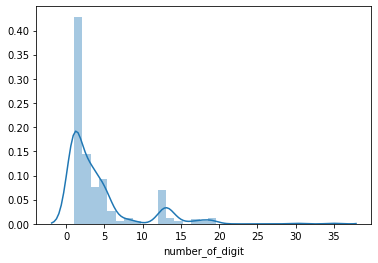

In [37]:
#istogramma per valutare le performance
from seaborn import distplot
distplot(award_crossYear_allFounded.number_of_digit)

In [38]:
#in base ai risiltati e alle preview, tutti quelli con numero di digit < 6 si considerano non identificati:
#ad esempio, ci sono titoli con una lettera, in quei casi e chiaro che non sia una buona pratica 
award_crossYear_good = award_crossYear_allFounded.copy()[award_crossYear_allFounded['number_of_digit'] >= 6].drop(
    ['number_of_digit', 'all_years'], axis = 1)
award_crossYear_good['source'] = 'cross_year'
award_crossYear_bad = award_crossYear_allFounded.copy()[award_crossYear_allFounded['number_of_digit'] < 6].drop(
    ['number_of_digit', 'all_years'], axis = 1)

In [39]:
print('Trovati title: ' + str(len(award_crossYear_allFounded.award_id.unique())))
print('Totali: ' + str(len(award_notFounded_api.award_id.unique())))

Trovati title: 154
Totali: 177


In [40]:
#concatenazione di tutti i trovati
award_merged_all = pd.concat([
    award_title_founded,
    award_originalTitle_founded,
    award_titleCleaned_founded,
    award_originalTitleCleaned_founded,
    award_founded_api,
    award_crossYear_good
], sort = True)

In [41]:
award_notFounded = data_award.copy()[
    data_award['award_id'].isin(award_merged_all['award_id'].tolist())==False
]

### DEDUPLICA

In [42]:
print('Record totali con duplicati: ' + str(award_merged_all.shape[0]))
#eliminazione dei record con duplicati per le coppie premio - film:
#significa che diversi metodi hanno portato allo stesso risultato
award_merged_all = award_merged_all.drop_duplicates(['award_id', 'movie_id'])

print('Record totali non duplicati: ' + str(award_merged_all.shape[0]))
print('Numero di premi: ' + str(award_merged_all.drop_duplicates('award_id').shape[0]))

Record totali con duplicati: 442876
Record totali non duplicati: 111036
Numero di premi: 13896


In [43]:
award_merged_all[award_merged_all['award_id'] == 'aw-10098']

,award,award_id,award_type,is_winner,movie_id,original_title,person,program,source,title,title_upper,year,year_movie
25533,Best Motion Picture - Musical or Comedy,aw-10098,golden globe,Nominee,m-22972,ROCKETMAN,[],Rocketman,upper_title,ROCKETMAN,ROCKETMAN,2019.0,1997.0
25534,Best Motion Picture - Musical or Comedy,aw-10098,golden globe,Nominee,m-167474,ROCKETMAN,[],Rocketman,upper_title,ROCKETMAN,ROCKETMAN,2019.0,2014.0
25535,Best Motion Picture - Musical or Comedy,aw-10098,golden globe,Nominee,m-354060,ROCKETMAN,[],Rocketman,upper_title,ROCKETMAN,ROCKETMAN,2019.0,2019.0
273718,Best Motion Picture - Musical or Comedy,aw-10098,golden globe,Nominee,m-511282,ELTON JOHN BECOMING ROCKETMAN,[],Rocketman,api,ELTON JOHN BECOMING ROCKETMAN,ROCKETMAN,2019.0,2019.0
273719,Best Motion Picture - Musical or Comedy,aw-10098,golden globe,Nominee,m-368316,ROCKETMAN: THE LUCKIEST MAN ON EARTH,[],Rocketman,api,ROCKETMAN: THE LUCKIEST MAN ON EARTH,ROCKETMAN,2019.0,2008.0
273720,Best Motion Picture - Musical or Comedy,aw-10098,golden globe,Nominee,m-447125,ROCKETMAN: MAD MIKE'S MISSION TO PROVE THE FLA...,[],Rocketman,api,ROCKETMAN: MAD MIKE'S MISSION TO PROVE THE FLA...,ROCKETMAN,2019.0,2019.0


In [44]:
#pulizia titoli tmdb
award_merged_all['title_upper_cleaned'] = award_merged_all['title_upper'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

award_merged_all['title_cleaned'] = award_merged_all['title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

award_merged_all['original_title_cleaned'] = award_merged_all['original_title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))


In [45]:
award_merged_all.head()

,award,award_id,award_type,is_winner,movie_id,original_title,person,program,source,title,title_upper,year,year_movie,title_upper_cleaned,title_cleaned,original_title_cleaned
0,ACTOR,aw-1,oscar award,Nominee,m-75734,THE NOOSE,[Richard Barthelmess],The Noose,upper_title,THE NOOSE,THE NOOSE,1927.0,1928.0,THENOOSE,THENOOSE,THENOOSE
1,ACTOR,aw-1,oscar award,Nominee,m-85671,PĘTLA,[Richard Barthelmess],The Noose,upper_title,THE NOOSE,THE NOOSE,1927.0,1958.0,THENOOSE,THENOOSE,PTLA
2,ACTOR,aw-1,oscar award,Nominee,m-515983,Η ΘΗΛΙΆ,[Richard Barthelmess],The Noose,upper_title,THE NOOSE,THE NOOSE,1927.0,2018.0,THENOOSE,THENOOSE,None
3,ACTOR,aw-2,oscar award,Winner,m-28205,THE LAST COMMAND,[Emil Jannings],The Last Command,upper_title,THE LAST COMMAND,THE LAST COMMAND,1927.0,1955.0,THELASTCOMMAND,THELASTCOMMAND,THELASTCOMMAND
4,ACTOR,aw-2,oscar award,Winner,m-35985,THE LAST COMMAND,[Emil Jannings],The Last Command,upper_title,THE LAST COMMAND,THE LAST COMMAND,1927.0,1928.0,THELASTCOMMAND,THELASTCOMMAND,THELASTCOMMAND


In [46]:
#recupero la popolarita'
award_merged = award_merged_all.copy().merge(
    tmdb_movies_complete[['movie_id', 'popularity', 'vote_average']],
    how = 'left', on = 'movie_id'
)

#ranking per popolarita'
award_merged['rank_pop'] = award_merged.groupby("award_id")["popularity"].rank(method="first", ascending=False)

In [47]:
#per la deduplica si applica la funzione di risoluzione utilizzata anche nell'enrichment dei programmi televisivi

#definizione dei livelli di priorita' attraverso un "indice di priorita'",
#l'indice si inizializza a zero e poi viene aggiornato nel modo seguente:
#se hanno lo stesso titolo l'indice aumenta di 2
#se il titolo del film e' contenuto nel titolo del df dei premi (titoli ripuliti e non), l'indice aumenta di 1
#se hanno lo stesso anno, l'indice aumenta di 1
#se la serie tv (o il film in alcuni casi) e' il primo nel ranking della popolarita' (ossia quello con popolarita' massima), l'indice aumenta di 1

#ad ogni iterazione si aggiorna anche il flag corrispondente all'aumento

award_merged['same_title'] = False
award_merged['title_is_in'] = False
award_merged['same_year'] = False
award_merged['title_cleaned_is_in'] = False
award_merged['is_max_pop'] = False
award_merged['priority'] = 0

In [48]:
#estraggo attributi rilevanti (per non incasinare il codice..)
for i in range(award_merged.shape[0]):
    original_title = award_merged['original_title'].iloc[i]
    title = award_merged['title'].iloc[i]
    title_upper = award_merged['title_upper'].iloc[i]
    original_title_cleaned = award_merged['original_title_cleaned'].iloc[i]
    title_cleaned = award_merged['title_cleaned'].iloc[i]
    title_upper_cleaned = award_merged['title_upper_cleaned'].iloc[i]
    year = award_merged['year'].iloc[i]
    year_movie = award_merged['year_movie'].iloc[i]
    
    #same title
    if (original_title == title_upper) | (title == title_upper):
        award_merged['same_title'].iloc[i] = True
        award_merged['priority'].iloc[i] += 2
    
    #title is in
    if pd.notnull(title):
        if (title in title_upper) | (title_upper in title):
            award_merged['title_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
    if (not award_merged['title_is_in'].iloc[i]) & pd.notnull(original_title):
        if (original_title in title_upper) | (title_upper in original_title):
            award_merged['title_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
            
    #title cleaned is in
    if pd.notnull(title_cleaned) & pd.notnull(title_upper_cleaned):
        if (title_cleaned in title_upper_cleaned) | (title_upper_cleaned in title_cleaned):
            award_merged['title_cleaned_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
    if (not award_merged['title_cleaned_is_in'].iloc[i]) & pd.notnull(original_title_cleaned) & pd.notnull(title_upper_cleaned):
        if (original_title_cleaned in title_upper_cleaned) | (title_upper_cleaned in original_title_cleaned):
            award_merged['title_cleaned_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
    
    #same year
    if year == year_movie:
        award_merged['same_year'].iloc[i] = True
        award_merged['priority'].iloc[i] += 1
    elif abs(year - year_movie) > 2:
        award_merged['priority'].iloc[i] -=1
        
    #max pop
    if award_merged['rank_pop'].iloc[i] == 1:
        award_merged['is_max_pop'].iloc[i] = True
        award_merged['priority'].iloc[i] += 1

C:\root\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [49]:
award_merged[award_merged['award_id']=='aw-10398']

,award,award_id,award_type,is_winner,movie_id,original_title,person,program,source,title,...,original_title_cleaned,popularity,vote_average,rank_pop,same_title,title_is_in,same_year,title_cleaned_is_in,is_max_pop,priority
25679,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-115256,BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE),[],Birdman,upper_title,BIRDMAN,...,BIRDMANORTHEUNEXPECTEDVIRTUEOFIGNORANCE,40.392,7.5,1.0,True,True,True,True,True,6
25680,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-298244,BIRDMAN,[],Birdman,upper_title,BIRDMAN,...,BIRDMAN,2.283,4.0,3.0,True,True,True,True,False,5
25681,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-428309,BIRDMAN,[],Birdman,upper_title,BIRDMAN,...,BIRDMAN,0.872,0.0,8.0,True,True,False,True,False,4
90925,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-746,BIRDMAN OF ALCATRAZ,[],Birdman,api,BIRDMAN OF ALCATRAZ,...,BIRDMANOFALCATRAZ,11.739,7.4,2.0,False,True,False,True,False,1
90926,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-394142,"HARVEY BIRDMAN, ATTORNEY GENERAL",[],Birdman,api,"HARVEY BIRDMAN, ATTORNEY GENERAL",...,HARVEYBIRDMANATTORNEYGENERAL,1.836,8.5,5.0,False,True,False,True,False,1
90927,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-492047,THE BIRDMAN,[],Birdman,api,THE BIRDMAN,...,THEBIRDMAN,1.171,0.0,6.0,False,True,False,True,False,1
90928,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-400632,BIRDMAN: ALL-ACCESS (A VIEW FROM THE WINGS),[],Birdman,api,BIRDMAN: ALL-ACCESS (A VIEW FROM THE WINGS),...,BIRDMANALLACCESSAVIEWFROMTHEWINGS,2.137,8.0,4.0,False,True,False,True,False,2
90929,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-140056,THE BALGONIE BIRDMAN,[],Birdman,api,THE BALGONIE BIRDMAN,...,THEBALGONIEBIRDMAN,0.600,0.0,9.0,False,True,False,True,False,1
90930,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-324076,DESCENT INTO THE MAELSTROM: THE UNTOLD STORY O...,[],Birdman,api,DESCENT INTO THE MAELSTROM: THE UNTOLD STORY O...,...,DESCENTINTOTHEMAELSTROMTHEUNTOLDSTORYOFRADIOBI...,0.931,6.0,7.0,False,True,False,True,False,1
90931,Best Motion Picture - Musical or Comedy,aw-10398,golden globe,Nominee,m-391505,AKU INGIN MENCIUMMU SEKALI SAJA,[],Birdman,api,BIRDMAN TALE,...,AKUINGINMENCIUMMUSEKALISAJA,0.600,6.0,10.0,False,True,False,True,False,1


In [50]:
#escludo quelli con priorita' pari a zero
award_merged_priority = award_merged.copy()[award_merged['priority'] > 0]

In [51]:
pd.DataFrame(
    award_merged_priority.groupby(['priority']).size()
).reset_index()

,priority,0
0,1,45959
1,2,8071
2,3,19502
3,4,3359
4,5,3515
5,6,9444


In [52]:
#frequenza dell'indice di priorita'
pd.DataFrame(
    award_merged_priority.groupby(['award_id'])['priority'].agg('max')
).reset_index()

,award_id,priority
0,aw-1,4
1,aw-10,3
2,aw-100,4
3,aw-1000,6
4,aw-10000,6
...,...,...
13863,aw-9995,6
13864,aw-9996,5
13865,aw-9997,3
13866,aw-9998,6


In [53]:
#riordino ed elimino i duplicati (di default viene tenuto il primo record, ossia quello con priorita' massima),
#se ci sono due programmi con stessa priorita' si prende il piu popolare
award_merged_max_pp = award_merged_priority.sort_values(['award_id', 'priority', 'popularity'], ascending = False).drop_duplicates('award_id')

In [54]:
award_merged_max_pp.head()

,award,award_id,award_type,is_winner,movie_id,original_title,person,program,source,title,...,original_title_cleaned,popularity,vote_average,rank_pop,same_title,title_is_in,same_year,title_cleaned_is_in,is_max_pop,priority
24728,COSTUME DESIGN,aw-9999,oscar award,Nominee,m-362956,JOJO RABBIT,[Mayes C. Rubeo],Jojo Rabbit,upper_title,JOJO RABBIT,...,JOJORABBIT,53.296,8.1,1.0,True,True,True,True,True,6
24727,COSTUME DESIGN,aw-9998,oscar award,Nominee,m-269036,THE IRISHMAN,[Sandy Powell and Christopher Peterson],The Irishman,upper_title,THE IRISHMAN,...,THEIRISHMAN,35.763,7.7,1.0,True,True,True,True,True,6
34300,CINEMATOGRAPHY,aw-9997,oscar award,Nominee,m-323567,ONCEUPONATIMEINHOLLYWOOD,[Robert Richardson],Once upon a Time...in Hollywood,cleaned_title,ONCEUPONATIMEINHOLLYWOOD,...,ONCEUPONATIMEINHOLLYWOOD,42.142,7.5,1.0,False,False,True,True,True,3
24724,CINEMATOGRAPHY,aw-9996,oscar award,Winner,m-376054,1917,[Roger Deakins],1917,upper_title,1917,...,None,143.817,7.9,1.0,True,True,True,False,True,5
24721,CINEMATOGRAPHY,aw-9995,oscar award,Nominee,m-353452,THE LIGHTHOUSE,[Jarin Blaschke],The Lighthouse,upper_title,THE LIGHTHOUSE,...,THELIGHTHOUSE,33.255,7.6,1.0,True,True,True,True,True,6


In [55]:
#frequenza dell'indice di priorita'
pd.DataFrame(
    award_merged_max_pp.groupby(['priority']).size()
).reset_index()

,priority,0
0,1,48
1,2,199
2,3,372
3,4,489
4,5,3316
5,6,9444


In [56]:
#estrazione dei premi non trovati (ossia quelli che non hanno nessu programma con priorita' diversa da zero)
award_merged_max_pp_not_founded = award_merged[['award', 'year', 'program', 'person', 'is_winner', 'award_type', 'title_upper', 'award_id']
            ].merge(award_merged_max_pp[['award_id', 'movie_id']], how = 'left', on = 'award_id')
award_merged_max_pp_not_founded = award_merged_max_pp_not_founded[
    pd.isnull(award_merged_max_pp_not_founded['movie_id'])
].drop_duplicates('award_id')

In [57]:
award_merged_max_pp_not_founded.shape[0]

28

In [58]:
print('Trovati correttamente: ' + str(award_merged_max_pp.shape[0]))
print('Non trovati: ' + str(award_notFounded.shape[0] + award_merged_max_pp_not_founded.shape[0]))
print('Premi totali con titolo non vuoto: ' + str(data_award.shape[0]))

Trovati correttamente: 13868
Non trovati: 158
Premi totali con titolo non vuoto: 14026


In [59]:
award_merged_max_pp.shape[0] + award_notFounded.shape[0] + award_merged_max_pp_not_founded.shape[0]

14026

In [60]:
award_notFounded['movie_id'] = None
award_merged_max_pp_not_founded['movie_id'] = None

pd.concat([
    award_merged_max_pp[['award', 'award_id', 'award_type', 'is_winner', 'person', 'movie_id', 'year']],
    award_merged_max_pp_not_founded[['award', 'award_id', 'award_type', 'is_winner', 'person', 'movie_id', 'year']].drop_duplicates('award_id'),
    award_notFounded[['award', 'award_id', 'award_type', 'is_winner', 'person', 'movie_id', 'year']]
]).to_pickle(path_data + 'awards/integrated/award_movies_final.df')